In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from datetime import datetime

import os
import sys
cur_dir = os.path.dirname(os.path.abspath("__file__"))  # Gets the current notebook directory
src_dir = os.path.join(cur_dir, '../')  # Constructs the path to the 'src' directory
# Add the 'src' directory to sys.path
if src_dir not in sys.path:
    sys.path.append(src_dir)

from src.constant import *
from tqdm.notebook import tqdm

from src.MyDataset import MyDataset
from src.TemporalFusionTransformer import TemporalFusionTransformer

from src.VQVAE import VQVAE
from typing import Optional

In [52]:
import torch.utils
import torch.utils.data


lookback = 30
future_steps = 40
dir = '../data/GeneratedFeatures'
ds = MyDataset(lookback=lookback)
train_batch_size = 16
test_batch_size = 64

def process_data(df_dir : str, target_freq : int = 10):
    df: pd.DataFrame = pd.read_csv(df_dir)
    df.columns = [col.strip() for col in df.columns]
    
    if 'state' in df.columns:
        states_ohe = pd.get_dummies(df['state'], prefix='state')
        df = pd.concat([df, states_ohe], axis=1)
        df.drop(columns=['state'], inplace=True)
        
    
        
    df.dropna(inplace=True, how='any')
    # f_per_sec = df.groupby('TimestampID').count().mean().mean()
    # if f_per_sec < target_freq:
    #     raise ValueError('The frequency of the data is lower than the target frequency')
    # elif int(f_per_sec) == target_freq:
    #     pass
    # else:
    #     resample_ratio = int(f_per_sec/target_freq)
    #     df = df.iloc[::resample_ratio, :]
    # # for origin
    for drop_column in ['Confidence', 'Timestamp', 'TimestampID', 
                          'DatapointID', 'PID', 'SCN', 'U_X', 'U_Y', 'U_Z', 
                          'AGV_Z', 'User_Z', 'GazeOrigin_Z', 'User_Pitch', 'User_Yaw', 'User_Roll', 
                          'EyeTarget', 
                          'start_station_X', 'start_station_Y', 'end_station_X', 'end_station_Y',
                          'distance_from_start_station_X',
                            'distance_from_start_station_Y', 'distance_from_end_station_X',
                            'distance_from_end_station_Y', 'facing_start_station',
                            'facing_end_station', 
                            'rolling_avg', 
                            
                            'possible_interaction', 
                          ]:
        df = df.drop(columns=[drop_column], errors='ignore')

    target_columns = ['User_X', 'User_Y']
    # Reorder columns
    new_columns = target_columns + [col for col in df.columns if col not in target_columns]
    df = df[new_columns]
    
    # keep numeric columns
    df = df.apply(pd.to_numeric, errors='ignore')

    return df

for file in os.listdir(dir):
    if file.endswith('.csv'):
        df = process_data(os.path.join(dir, file))
        ds.read_data(df)


### Optional: shuffle the dataset

In [ ]:
# import random
# random.shuffle(ds.dataset)

In [ ]:
stats_dict = {'mean': 0, 'std': 0, 'min': 0, 'max': 0}
stats_dict = ds.normalize_dataset()
ds.generate_data(future_steps=future_steps)

train:torch.utils.data.DataLoader
test:torch.utils.data.DataLoader

train, test = ds.split_data(frac=0.9, shuffle=True, train_batch_size=train_batch_size, test_batch_size=test_batch_size)
feature_dim = ds.feature_dim
columns = [_ for _ in ds.dataset[0].columns if _ not in ['AGV_name']]
print(f"columns : {columns} \nfeature_dim : {feature_dim}")


columns : Index(['User_X', 'User_Y', 'AGV_name', 'AGV_distance_X', 'AGV_distance_Y',
       'AGV_speed_X', 'AGV_speed_Y', 'AGV_speed', 'User_speed_X',
       'User_speed_Y', 'User_speed', 'User_velocity_X', 'User_velocity_Y',
       'Wait_time', 'intent_to_cross', 'Gazing_station',
       'facing_along_sidewalk', 'facing_to_road', 'On_sidewalks', 'On_road',
       'closest_station', 'distance_to_closest_station',
       'distance_to_closest_station_X', 'distance_to_closest_station_Y',
       'looking_at_AGV', 'GazeDirection_X', 'GazeDirection_Y',
       'GazeDirection_Z', 'AGV_X', 'AGV_Y', 'looking_at_closest_station'],
      dtype='object') 
feature_dim : 30


['User_X', 'User_Y', 'AGV_distance_X', 'AGV_distance_Y', 'AGV_speed_X',
       'AGV_speed_Y', 'AGV_speed', 'User_speed_X', 'User_speed_Y',
       'User_speed', 'User_velocity_X', 'User_velocity_Y', 'Wait_time',
       'intent_to_cross', 'Gazing_station', 'possible_interaction',
       'facing_along_sidewalk', 'facing_to_road', 'On_sidewalks', 'On_road',
       'closest_station', 'distance_to_closest_station',
       'distance_to_closest_station_X', 'distance_to_closest_station_Y',
       'looking_at_AGV', 'GazeDirection_X', 'GazeDirection_Y',
       'GazeDirection_Z', 'AGV_X', 'AGV_Y', 'looking_at_closest_station']

In [54]:
for i, (X, y) in enumerate(train):
    print(X.shape, y.shape)
    break

print(len(train), len(test))

torch.Size([16, 30, 30]) torch.Size([16, 40, 30])
11136 310


In [55]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device}")

# model = TemporalFusionTransformer(num_features=feature_dim, 
#                                   num_hidden=128, num_outputs=2, 
#                                   num_steps=future_steps)
# optimizer = optim.AdamW(model.parameters(), lr=2e-4)
# model.to(device)


vqvae = VQVAE(input_dim=feature_dim, hidden_dim=512, num_embeddings=128, embedding_dim=128, commitment_cost=0.25)

class EnhancedTFT(nn.Module):
    def __init__(self, num_features, num_hidden, num_outputs, num_steps, vqvae:VQVAE):
        super(EnhancedTFT, self).__init__()
        self.vqvae = vqvae
        self.tft = TemporalFusionTransformer(num_features + vqvae.encoder.fc2.out_features, num_hidden, num_outputs, num_steps, num_attention_heads=8)
        self.num_outputs = num_outputs
        self.num_steps = num_steps
        
    def forward(self, x, mask: Optional[torch.Tensor]=None):
        x_recon, vq_loss, perplexity, embedding = self.vqvae(x)
        x_enhanced = torch.cat((x, embedding), dim=-1)
        return self.tft(x_enhanced, mask), vq_loss, perplexity

model = EnhancedTFT(num_features=feature_dim, num_hidden=128, num_outputs=2, num_steps=future_steps, vqvae=vqvae)
optimizer = optim.AdamW(model.parameters(), lr=2e-4)
model.to(device)

Using cuda


EnhancedTFT(
  (vqvae): VQVAE(
    (encoder): VQVAEEncoder(
      (fc1): Linear(in_features=30, out_features=512, bias=True)
      (fc2): Linear(in_features=512, out_features=128, bias=True)
    )
    (quantizer): VectorQuantizer(
      (embedding): Embedding(128, 128)
    )
    (decoder): VQVAEDecoder(
      (fc1): Linear(in_features=128, out_features=512, bias=True)
      (fc2): Linear(in_features=512, out_features=30, bias=True)
    )
  )
  (tft): TemporalFusionTransformer(
    (encoder_grn): GatedResidualNetwork(
      (layers): ModuleList(
        (0): Linear(in_features=158, out_features=128, bias=True)
        (1-2): 2 x Linear(in_features=128, out_features=128, bias=True)
      )
      (norms): ModuleList(
        (0-2): 3 x LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
      (dropout): Dropout(p=0.1, inplace=False)
      (fc2): Linear(in_features=128, out_features=128, bias=True)
      (fc3): Linear(in_features=158, out_features=128, bias=True)
      (gate): Li

### Customized Loss Function

In [56]:
class DecayLoss(nn.Module):
    def __init__(self, num_steps, baseline_loss_fn=nn.L1Loss()):
        super(DecayLoss, self).__init__()
        # Weight decreases as we move further into the future
        self.weights = torch.linspace(1.0, 1.0, num_steps)
        self.baseline_loss_fn = baseline_loss_fn
        

    def forward(self, predictions, targets):
        loss = 0
        for i in range(predictions.shape[1]):
            loss += self.weights[i] * self.baseline_loss_fn(predictions[:, i], targets[:, i])
        return loss
    
baseline_loss_fn = nn.L1Loss() #nn.MSELoss()
loss_fn = DecayLoss(future_steps, baseline_loss_fn=baseline_loss_fn)

### Trainer with early stop

In [57]:
# Parameters
n_epochs = 10
eval_step = 500
save_every = 10000
patience = 8  # Number of evaluations to wait for improvement
cooldown = 4  # Evaluations to wait after an improvement before counting non-improvements
smooth_factor = 0.6  # Smoothing factor for moving average

# Setup
train_all = len(train)
model_name = "TFT_vqvae"
loss_all = []
best_test_rmse = float('inf')
early_stopping_counter = 0
cooldown_counter = cooldown

now = datetime.now()
folder_name = now.strftime("%b%d_%H-%M-%S")
os.makedirs(f'../model/{model_name}/{folder_name}', exist_ok=True)
print(f"Saving model at ../model/{model_name}/{folder_name}")

# Initialize moving average
moving_avg_test_rmse = None

# Training loop
for epoch in range(n_epochs):
    model.train()
    for step, (X_batch, y_batch) in tqdm(enumerate(train), total=train_all):
        X_batch = X_batch.float().to(device)
        y_batch = y_batch.float().to(device)
        
        current_pos_input = X_batch[:, -1, :2].clone().unsqueeze(1).repeat(1, lookback, 1)
        current_pos_output = X_batch[:, -1, :2].clone().unsqueeze(1).repeat(1, future_steps, 1)
        X_batch[:, :, :2] = X_batch[:, :, :2] - current_pos_input
        y_batch[:, :, :2] = y_batch[:, :, :2] - current_pos_output
        optimizer.zero_grad()
        
        y_pred, vq_loss, perplexity = model(X_batch)
        loss = loss_fn(y_pred[:, :future_steps, :2], y_batch[:, :future_steps, :2])
        loss_all.append(loss.item())
        
        # add vq_loss
        loss += 10 * vq_loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        # Save model
        if (epoch * train_all + step + 1) % save_every == 0:
            save_path = f"../model/{model_name}/{folder_name}/model_{epoch * train_all + step + 1}.pt"
            torch.save(model.state_dict(), save_path)
            print(f"Model saved at {save_path}")

        # Validation and early stopping
        if (epoch * train_all + step + 1) % eval_step == 0:
            model.eval()
            test_rmse_all = []
            with torch.no_grad():
                for X_test_batch, y_test_batch in test:
                    X_test_batch = X_test_batch.float().to(device)
                    y_test_batch = y_test_batch.float().to(device)
                    
                    current_pos_input = X_test_batch[:, -1, :2].clone().unsqueeze(1).repeat(1, lookback, 1)
                    current_pos_output = X_test_batch[:, -1, :2].clone().unsqueeze(1).repeat(1, future_steps, 1)
                    X_test_batch[:, :, :2] = X_test_batch[:, :, :2] - current_pos_input
                    y_test_batch[:, :, :2] = y_test_batch[:, :, :2] - current_pos_output
                    
                    y_pred_test, vq_loss, perplexity = model(X_test_batch)
                    loss_test = loss_fn(y_pred_test[:, :future_steps, :2], y_test_batch[:, :future_steps, :2])
                    test_rmse = torch.sqrt(loss_test)
                    if not torch.isnan(test_rmse):
                        test_rmse_all.append(test_rmse.item())
            
            current_rmse = sum(test_rmse_all) / len(test_rmse_all)
            if moving_avg_test_rmse is None:
                moving_avg_test_rmse = current_rmse
            else:
                moving_avg_test_rmse = smooth_factor * current_rmse + (1 - smooth_factor) * moving_avg_test_rmse

            print(f"Steps {epoch * train_all + step + 1}: test RMSE {current_rmse:.4f}, moving average RMSE {moving_avg_test_rmse:.4f}")

            # Check if the moving average RMSE is better; if not, increment counter
            if moving_avg_test_rmse < best_test_rmse:
                best_test_rmse = moving_avg_test_rmse
                early_stopping_counter = 0  # Reset counter
                cooldown_counter = cooldown  # Reset cooldown
                # Optionally save the best model
                best_model_path = f"../model/{model_name}/{folder_name}/best_model.pt"
                torch.save(model.state_dict(), best_model_path)
            else:
                if cooldown_counter > 0:
                    cooldown_counter -= 1
                else:
                    early_stopping_counter += 1

            if early_stopping_counter >= patience:
                print(f"Stopping early at epoch {epoch+1}, step {step+1}")
                break

            model.train()
        
    if early_stopping_counter >= patience:
        break

print("Training complete.")

Saving model at ../model/TFT_vqvae/Nov12_03-22-30


  0%|          | 0/11136 [00:00<?, ?it/s]

Steps 500: test RMSE 0.8369, moving average RMSE 0.8369
Steps 1000: test RMSE 0.7397, moving average RMSE 0.7786
Steps 1500: test RMSE 0.7127, moving average RMSE 0.7391
Steps 2000: test RMSE 0.6890, moving average RMSE 0.7090
Steps 2500: test RMSE 0.6778, moving average RMSE 0.6903
Steps 3000: test RMSE 0.6864, moving average RMSE 0.6880
Steps 3500: test RMSE 0.6165, moving average RMSE 0.6451
Steps 4000: test RMSE 0.6247, moving average RMSE 0.6329
Steps 4500: test RMSE 0.6183, moving average RMSE 0.6241
Steps 5000: test RMSE 0.6303, moving average RMSE 0.6278
Steps 5500: test RMSE 0.5964, moving average RMSE 0.6090
Steps 6000: test RMSE 0.6079, moving average RMSE 0.6083
Steps 6500: test RMSE 0.6045, moving average RMSE 0.6060
Steps 7000: test RMSE 0.6199, moving average RMSE 0.6143
Steps 7500: test RMSE 0.5851, moving average RMSE 0.5968
Steps 8000: test RMSE 0.5896, moving average RMSE 0.5925
Steps 8500: test RMSE 0.5762, moving average RMSE 0.5827
Steps 9000: test RMSE 0.5891, mo

  0%|          | 0/11136 [00:00<?, ?it/s]

Steps 11500: test RMSE 0.5746, moving average RMSE 0.5762
Steps 12000: test RMSE 0.5844, moving average RMSE 0.5811
Steps 12500: test RMSE 0.5660, moving average RMSE 0.5720
Steps 13000: test RMSE 0.5722, moving average RMSE 0.5721
Steps 13500: test RMSE 0.5624, moving average RMSE 0.5663
Steps 14000: test RMSE 0.5594, moving average RMSE 0.5622
Steps 14500: test RMSE 0.5879, moving average RMSE 0.5776
Steps 15000: test RMSE 0.5719, moving average RMSE 0.5742
Steps 15500: test RMSE 0.5629, moving average RMSE 0.5674
Steps 16000: test RMSE 0.5602, moving average RMSE 0.5631
Steps 16500: test RMSE 0.5876, moving average RMSE 0.5778
Steps 17000: test RMSE 0.5600, moving average RMSE 0.5671
Steps 17500: test RMSE 0.5718, moving average RMSE 0.5700
Steps 18000: test RMSE 0.5500, moving average RMSE 0.5580
Steps 18500: test RMSE 0.5692, moving average RMSE 0.5647
Steps 19000: test RMSE 0.5641, moving average RMSE 0.5643
Steps 19500: test RMSE 0.5623, moving average RMSE 0.5631
Model saved at

KeyboardInterrupt: 

In [58]:
validation_step = future_steps

predictions = []
truths = []

with torch.no_grad():
    model.eval()
    all_test = len(test)
    test_rmse_all = []
    for X_test_batch, y_test_batch in tqdm(test):
        X_test_batch = X_test_batch.float().to(device)
        y_test_batch = y_test_batch.float().to(device)
        
        current_pos_input = X_test_batch[:, -1, :2].clone().unsqueeze(1).repeat(1, lookback, 1)
        current_pos_output = X_test_batch[:, -1, :2].clone().unsqueeze(1).repeat(1, future_steps, 1)
        X_test_batch[:, :, :2] = X_test_batch[:, :, :2] - current_pos_input
        y_test_batch[:, :, :2] = y_test_batch[:, :, :2] - current_pos_output
        
        y_pred, vq_loss, perplexity = model(X_test_batch)
        predictions.append(y_pred[:, :validation_step, :2] + current_pos_output)
        truths.append(y_test_batch[:, :validation_step, :2] + current_pos_output)
        
predictions = torch.cat(predictions, dim=0)
truths = torch.cat(truths, dim=0)

  0%|          | 0/310 [00:00<?, ?it/s]

In [59]:
# reverse normalization
normalize_dict = stats_dict

for idx, key_ in enumerate(["User_X", "User_Y"]):
    predictions[:, :, idx] = predictions[:, :, idx] * (normalize_dict['max'][key_] - normalize_dict['min'][key_]) + normalize_dict['min'][key_]
    predictions[:, :, idx] = predictions[:, :, idx] * normalize_dict['std'][key_] + normalize_dict['mean'][key_]
    truths[:, :, idx] = truths[:, :, idx] * (normalize_dict['max'][key_] - normalize_dict['min'][key_]) + normalize_dict['min'][key_]
    truths[:, :, idx] = truths[:, :, idx] * normalize_dict['std'][key_] + normalize_dict['mean'][key_]

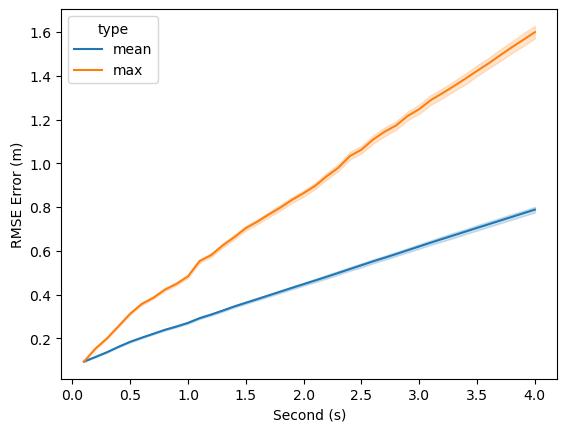

In [62]:
criterion = nn.MSELoss(reduction="none")

steps = []
loss = []
max_loss = []
for step in range(1, future_steps+1):
    raw_rmse_loss = criterion(predictions[:, :step, :], truths[:, :step, :])
    raw_rmse_loss = torch.sqrt(torch.sum(raw_rmse_loss, dim=-1))
    mean_rmse_loss = raw_rmse_loss.mean(dim=-1)
    max_rmse_loss = raw_rmse_loss.max(dim=-1).values
    loss.append(mean_rmse_loss)
    max_loss.append(max_rmse_loss)
    steps.extend([step] * len(mean_rmse_loss))
    
max_loss = torch.cat(max_loss).cpu().numpy()
loss = torch.cat(loss).cpu().numpy()

df = pd.DataFrame({'Second (s)': steps, 'loss': loss})
df1 = pd.DataFrame({'Second (s)': steps, 'loss': max_loss})
df['type'] = 'mean'
df1['type'] = 'max'
df = pd.concat([df, df1])


df['RMSE Error (m)'] = df['loss'] / 100 # to meters
df['Second (s)'] = df['Second (s)'] / 10 # to seconds
sns.lineplot(data = df, x='Second (s)', y='RMSE Error (m)', hue='type',) #  errorbar=('sd', 1),
plt.savefig('../figure/TFT_manual_shuffle_relative_vqvae_UE_1011.png')
plt.show()

In [61]:
exp_results = df.groupby(by=['Second (s)', 'type']).mean().unstack()['RMSE Error (m)']
exp_results.to_csv(f'../model/{model_name}/{folder_name}/result.csv')
exp_results.tail(10)

type,max,mean
Second (s),,
3.1,1.288924,0.637749
3.2,1.320424,0.654595
3.3,1.352972,0.671301
3.4,1.387378,0.688108
3.5,1.422457,0.704904
3.6,1.456835,0.721704
3.7,1.493793,0.738392
3.8,1.530365,0.755042
3.9,1.564420,0.771881


### Export JIT Model

Integrate partial of data processing into the model

In [64]:
# EXPORT_MODEL = True

# # model.load_state_dict(torch.load("/home/shaoze/Documents/Boeing/Boeing-Trajectory-Prediction/model/Jul09_20-37-37/model_40000.pt"))
# if EXPORT_MODEL:
#     model.eval()
#     model.to('cpu')
#     script_module = torch.jit.script(model)
#     os.makedirs(f'../model/exported/', exist_ok=True)
#     script_module.save("../exported/model_tft_vqvae_cpu.pt")

stats = {}
'''
mean: tensor[]
'''

for keys, values in stats_dict.items():
    stats[keys] = torch.tensor(values.to_list()).view(1,1,-1)
    
class TFT_EXP(nn.Module):
    def __init__(self, model:EnhancedTFT, stats:dict):
        super(TFT_EXP, self).__init__()
        self.stats = stats
        self.register_buffer('mean', self.stats['mean'])
        self.register_buffer('std', self.stats['std'])
        self.register_buffer('min', self.stats['min'])
        self.register_buffer('max', self.stats['max'])
        self.TFT = model
        self.num_steps = model.num_steps
        self.num_outputs = model.num_outputs # =2

    def forward(self, x, mask: Optional[torch.Tensor]=None):
        single = False
        if len(x.shape) == 2:
            x = x.unsqueeze(0)
            single = True
        
        # normalize
        x = (x - self.mean) / self.std
        x = (x - self.min) / (self.max - self.min)
        # residual
        current_pos_input = x[:, -1, :2].clone().unsqueeze(1).repeat(1, x.shape[1], 1)
        current_pos_output = x[:, -1, :2].clone().unsqueeze(1).repeat(1, self.num_steps, 1)
        x[:, :, :2] = x[:, :, :2] - current_pos_input
        
        # pass through TFT
        outputs, vq_loss, perplexity = self.TFT(x, mask)
        outputs = outputs.detach()
        
        # de-residual
        outputs[:, :, :2] = outputs[:, :, :2] + current_pos_output
        
        # denormalize
        outputs = outputs * (self.max[:,:,:self.num_outputs] - self.min[:,:,:self.num_outputs]) + self.min[:,:,:self.num_outputs]
        outputs = outputs * self.std[:,:,:self.num_outputs] + self.mean[:,:,:self.num_outputs]
        
        if single:
            outputs = outputs.squeeze(0)
        return outputs

tft_exp = TFT_EXP(model, stats)
tft_exp.to('cpu')
tft_exp.eval()
# script_module = torch.jit.script(tft_exp)
# os.makedirs(f'../model/exported/', exist_ok=True)
# script_module.save("../exported/model_tft_vqvae_cpu_preproc.pt")

# export to onnx

dummy_input = torch.randn(1, lookback, feature_dim)
print(f"Input shape: {dummy_input.shape}")

# Export the wrapped model to ONNX format
torch.onnx.export(
    tft_exp,                   # Wrapped model to export
    dummy_input,                     # Model input
    "../exported/tft_1111_UE.onnx",              # Output file name
    export_params=True,              # Store the trained parameter weights inside the model file
    opset_version=13,                # Set the ONNX opset version (adjust as needed)
    do_constant_folding=True,        # Whether to execute constant folding for optimization
    input_names=['input'],           # The model's input names
    output_names=['output'],         # The model's output names
    # dynamic_axes={
    #     'input': {0: 'batch_size'},  # Dynamic batch_size and sequence_length
    #     'output': {0: 'batch_size'}  # Dynamic batch_size for the output
    # }
)
        

Input shape: torch.Size([1, 30, 30])


In [73]:
import onnxruntime as ort
import numpy as np

# Path to your ONNX model
model_path = "../exported/tft_1111_UE.onnx"

# Create an inference session
session = ort.InferenceSession(model_path)

# Get the name of the input node
input_name = session.get_inputs()[0].name

for file in os.listdir(dir):
    if file.endswith('.csv'):
        df = pd.read_csv(os.path.join(dir, file))
    break

df.columns = [col.strip() for col in df.columns]
df = df[['User_X', 'User_Y', 'AGV_distance_X', 'AGV_distance_Y',
       'AGV_speed_X', 'AGV_speed_Y', 'AGV_speed', 'User_speed_X',
       'User_speed_Y', 'User_speed', 'User_velocity_X', 'User_velocity_Y',
       'Wait_time', 'intent_to_cross', 'Gazing_station',
       'facing_along_sidewalk', 'facing_to_road', 'On_sidewalks', 'On_road',
       'closest_station', 'distance_to_closest_station',
       'distance_to_closest_station_X', 'distance_to_closest_station_Y',
       'looking_at_AGV', 'GazeDirection_X', 'GazeDirection_Y',
       'GazeDirection_Z', 'AGV_X', 'AGV_Y', 'looking_at_closest_station'
       ]]

start_idx = 100
input = df.iloc[200:200+lookback].astype(np.float32).values

# add batch
input = input[np.newaxis, :, :]
# Run the model
output = session.run(None, {input_name: input.astype(np.float32)})[0]

output


array([[[1651.7168, 5799.6973],
        [1652.9893, 5799.642 ],
        [1662.2144, 5800.4507],
        [1654.0767, 5800.774 ],
        [1654.6855, 5801.7227],
        [1666.8799, 5800.0273],
        [1648.9961, 5799.416 ],
        [1655.1187, 5799.092 ],
        [1656.9316, 5799.3984],
        [1664.3594, 5798.341 ],
        [1660.7168, 5801.892 ],
        [1654.0347, 5799.4526],
        [1651.5513, 5803.042 ],
        [1661.8765, 5798.841 ],
        [1651.6641, 5799.411 ],
        [1659.9248, 5796.8037],
        [1656.6572, 5799.4453],
        [1659.8604, 5801.0967],
        [1660.5122, 5798.7485],
        [1644.1621, 5799.06  ],
        [1654.1362, 5799.204 ],
        [1651.1729, 5799.3687],
        [1663.3989, 5801.0474],
        [1654.8066, 5801.2695],
        [1655.7583, 5798.706 ],
        [1652.544 , 5799.01  ],
        [1654.4316, 5800.5537],
        [1644.4434, 5798.73  ],
        [1657.8838, 5806.4595],
        [1655.9102, 5801.345 ],
        [1647.437 , 5804.7407],
        

### Save data (for interactive visualization)

In [ ]:
model = torch.jit.load("../exported/model_tft_vqvae_cpu.pt")

test_ds = MyDataset(lookback=lookback)
all_ds = ds.dataset
test_ds.dataset = all_ds[len(all_ds)//10 :] # load the last 10% of the data
X_list, y_list = test_ds.generate_data(return_list=True, future_steps=future_steps)


In [ ]:
from torch.utils.data import DataLoader, Dataset, TensorDataset

normalize_dict = stats_dict
pred_data = []
truth_data = []
input_data = []
model.eval()
device = 'cpu'
for i, (X, y) in enumerate(zip(X_list, y_list)):
    current_pos_input = X[:, -1, :2].clone().unsqueeze(1).repeat(1, lookback, 1)
    current_pos_output = X[:, -1, :2].clone().unsqueeze(1).repeat(1, future_steps, 1).to(device)
    X[:, :, :2] = X[:, :, :2] - current_pos_input

    predictions = model(X.float().to(device))[0][:, :future_steps, :2]
    predictions = predictions + current_pos_output
    predictions = predictions.to('cpu')
    
    truths = y[:, :future_steps, :2]
    X[:, :, :2] = X[:, :, :2] + current_pos_input
    model_input = X.float().to(device)[:, :lookback, :2]
    trajectory_id = i
    
    # reverse normalization
    for idx, key_ in enumerate(["User_X", "User_Y"]):
        predictions[:, :, idx] = predictions[:, :, idx] * (normalize_dict['max'][key_] - normalize_dict['min'][key_]) + normalize_dict['min'][key_]
        predictions[:, :, idx] = predictions[:, :, idx] * normalize_dict['std'][key_] + normalize_dict['mean'][key_]
        truths[:, :, idx] = truths[:, :, idx] * (normalize_dict['max'][key_] - normalize_dict['min'][key_]) + normalize_dict['min'][key_]
        truths[:, :, idx] = truths[:, :, idx] * normalize_dict['std'][key_] + normalize_dict['mean'][key_]
        model_input[:, :, idx] = model_input[:, :, idx] * (normalize_dict['max'][key_] - normalize_dict['min'][key_]) + normalize_dict['min'][key_]
        model_input[:, :, idx] = model_input[:, :, idx] * normalize_dict['std'][key_] + normalize_dict['mean'][key_]
    
    for group_id in range(predictions.shape[0]):
        for time_step in range(predictions.shape[1]):
            pred_x, pred_y = predictions[group_id, time_step]
            pred_data.append([trajectory_id, group_id, time_step, pred_x.item(), pred_y.item()])

            truth_x, truth_y = truths[group_id, time_step]
            truth_data.append([trajectory_id, group_id, time_step, truth_x.item(), truth_y.item()])
        
        for time_step in range(lookback):
            input_x, input_y = model_input[group_id, time_step]
            input_data.append([trajectory_id, group_id, time_step, input_x.item(), input_y.item()])
            

pred_df = pd.DataFrame(pred_data, columns=['trajectory_id', 'Group_ID', 'Time_Step', 'X', 'Y'])
truth_df = pd.DataFrame(truth_data, columns=['trajectory_id', 'Group_ID', 'Time_Step', 'X', 'Y'])
input_df = pd.DataFrame(input_data, columns=['trajectory_id', 'Group_ID', 'Time_Step', 'X', 'Y'])


In [ ]:
files_to_remove = [
    "../data/pred_tra_all.pkl",
    "../data/truth_tra_all.pkl", 
    "../data/input_tra_all.pkl"
]

for file_path in files_to_remove:
    if os.path.exists(file_path):
        os.remove(file_path)

truth_df.to_pickle("../data/truth_tra_all.pkl")
pred_df.to_pickle("../data/pred_tra_all.pkl")
input_df.to_pickle("../data/input_tra_all.pkl")